In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle) # if there's an "SavedModel file does not exist at:", delete that folder and rerun it

2023-03-01 08:54:36.728033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 08:54:43.780416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_all = pd.read_csv('../train_val_test_split/train_val_test_GoogleAudioSet.csv', index_col=0)
df_all

,file,source,category,weight,fold
0,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,0
1,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8
2,../data/interim/GoogleAudioSet_unbalanced_list...,Google_nature,0,1,5
3,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,1
4,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,1
...,...,...,...,...,...
13662,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,5
13663,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,3
13664,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8
13665,../data/interim/GoogleAudioSet_unbalanced_list...,Google_city,1,1,8


In [3]:
# check the weight
df_all.groupby(['source'])['weight'].sum()

source
Google_city      6687
Google_nature    6980
Name: weight, dtype: int64

# Convert data into TF format

In [4]:
def load_wav_pkl(filename, wav_label='y'):
    import pickle
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    wav = output[wav_label]

    # close the file
    file.close()
    return wav

wav_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'])) == 160000:
        wav_list.append(load_wav_pkl(row['file']))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'])
#         print('short length: '+str(len(temp_wav)))
        wav_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_bg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'bg_y')) == 160000:
        wav_bg_list.append(load_wav_pkl(row['file'], 'bg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'bg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_bg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_fg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'fg_y')) == 160000:
        wav_fg_list.append(load_wav_pkl(row['file'], 'fg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'fg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_fg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

short length: 149778
short length: 159880
short length: 145067
short length: 150467
short length: 159804
short length: 146604
short length: 114428
short length: 159880
short length: 146100
short length: 158862
short length: 146850
short length: 159880
short length: 159993
short length: 153559
short length: 148807
short length: 143407
short length: 158047
short length: 159999
short length: 145688
short length: 159996
short length: 141887
short length: 159880
short length: 145364
short length: 144993
short length: 159995
short length: 159880
short length: 91022
short length: 151412
short length: 159880
short length: 152596
short length: 159999
short length: 159999
short length: 148831
short length: 153812
short length: 159880
short length: 156559
short length: 149675
short length: 149725
short length: 89536
short length: 158583
short length: 128917
short length: 159880
short length: 150069
short length: 158739
short length: 152920
short length: 151580
short length: 147395
short length: 1

short length: 159880
short length: 101796
short length: 159880
short length: 152399
short length: 148236
short length: 152994
short length: 151853
short length: 159880
short length: 146456
short length: 159987
short length: 151159
short length: 157205
short length: 156908
short length: 153828
short length: 153909
short length: 159880
short length: 150616
short length: 159880
short length: 159880
short length: 146924
short length: 159880
short length: 146193
short length: 153791
short length: 156837
short length: 159880
short length: 149775
short length: 159880
short length: 144305
short length: 149938
short length: 152078
short length: 150590
short length: 159999
short length: 154059
short length: 145636
short length: 159880
short length: 150199
short length: 152756
short length: 153142
short length: 158887
short length: 157896
short length: 145290
short length: 146010
short length: 146604
short length: 159996
short length: 150542
short length: 154817
short length: 153554
short length:

short length: 145736
short length: 153737
short length: 152972
short length: 103840
short length: 147199
short length: 157427
short length: 148708
short length: 159996
short length: 153444
short length: 159880
short length: 98081
short length: 150123
short length: 159880
short length: 158616
short length: 159880
short length: 159880
short length: 155696
short length: 147883
short length: 142478
short length: 158765
short length: 145785
short length: 110341
short length: 159999
short length: 150493
short length: 155767
short length: 159880
short length: 153909
short length: 146619
short length: 139320
short length: 153266
short length: 151828
short length: 159880
short length: 159880
short length: 77498
short length: 159880
short length: 159880
short length: 154359
short length: 152969
short length: 144169
short length: 159992
short length: 159880
short length: 152474
short length: 83592
short length: 153118
short length: 156861
short length: 155543
short length: 147536
short length: 15

short length: 153441
short length: 125202
short length: 150651
short length: 151235
short length: 159880
short length: 159880
short length: 110713
short length: 146628
short length: 99196
short length: 159880
short length: 155053
short length: 159880
short length: 151532
short length: 159998
short length: 159880
short length: 159880
short length: 159880
short length: 158566
short length: 159880
short length: 153948
short length: 148422
short length: 68360
short length: 159880
short length: 155995
short length: 159880
short length: 158562
short length: 158768
short length: 159880
short length: 149734
short length: 152224
short length: 154404
short length: 147544
short length: 148955
short length: 150714
short length: 145636
short length: 147271
short length: 151573
short length: 148213
short length: 145341
short length: 159880
short length: 154968
short length: 159880
short length: 159880
short length: 157603
short length: 144398
short length: 148040
short length: 159880
short length: 1

In [5]:
main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))


# applies the embedding extraction model to a wav data
def extract_embedding_weight(wav_data, label, fold, weight):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings),
            tf.repeat(weight, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding_weight).unbatch()
main_ds_fg = main_ds_fg.map(extract_embedding_weight).unbatch()
main_ds_bg = main_ds_bg.map(extract_embedding_weight).unbatch()

In [6]:
def split_ds(main_ds):
    cached_ds = main_ds.cache()
    train_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold < 8)
    val_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 8)
    test_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 9)

    # remove the folds column now that it's not needed anymore
    remove_fold_column = lambda embedding, label, fold, weight: (embedding, label, weight)

    train_ds = train_ds.map(remove_fold_column)
    val_ds = val_ds.map(remove_fold_column)
    test_ds = test_ds.map(remove_fold_column)

    train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = split_ds(main_ds)
train_ds_bg, val_ds_bg, test_ds_bg = split_ds(main_ds_bg)
train_ds_fg, val_ds_fg, test_ds_fg = split_ds(main_ds_fg)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Shared model parameters

In [22]:
# my_classes = ['city', 'nature']
# Sequential_model = [tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
#                     tf.keras.layers.Dropout(.5),
#                     tf.keras.layers.Dense(512, activation='relu'),
#                     tf.keras.layers.Dropout(.5),
# #                     tf.keras.layers.Dense(256, activation='relu'),
#                     tf.keras.layers.Dense(len(my_classes))
#                     ]

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)

# learning_rate=0.001

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

def get_model():
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(23)
    np.random.seed(23)
    python_random.seed(23)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2)   
    ])
    
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  weighted_metrics=['accuracy'],
                  metrics=['accuracy'])


    return model

# Model of raw signal

In [35]:
raw_model = get_model()

# raw_model = tf.keras.Sequential(Sequential_model, name='raw_model')

raw_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 147,970
Trainable params: 147,970
Non-trai

In [36]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# raw_model.compile(loss=loss_func,
#                   optimizer=optimizer,
#                   weighted_metrics=['accuracy'],
#                   metrics=['accuracy'])


history_raw = raw_model.fit(train_ds,
                            epochs=20,
                            validation_data=val_ds,
                            callbacks=callback)

Epoch 1/20
7459/7459 [==============================] - 21s 3ms/step - loss: 0.6181 - accuracy: 0.6614 - weighted_accuracy: 0.6614 - val_loss: 0.6232 - val_accuracy: 0.6582 - val_weighted_accuracy: 0.6582
Epoch 2/20
7459/7459 [==============================] - 23s 3ms/step - loss: 0.6103 - accuracy: 0.6648 - weighted_accuracy: 0.6648 - val_loss: 0.6291 - val_accuracy: 0.6576 - val_weighted_accuracy: 0.6576
Epoch 3/20
7459/7459 [==============================] - 19s 3ms/step - loss: 0.6092 - accuracy: 0.6663 - weighted_accuracy: 0.6663 - val_loss: 0.6289 - val_accuracy: 0.6580 - val_weighted_accuracy: 0.6580
Epoch 4/20
7459/7459 [==============================] - 27s 4ms/step - loss: 0.6090 - accuracy: 0.6663 - weighted_accuracy: 0.6663 - val_loss: 0.6277 - val_accuracy: 0.6654 - val_weighted_accuracy: 0.6654
Epoch 5/20
7459/7459 [==============================] - 22s 3ms/step - loss: 0.6091 - accuracy: 0.6663 - weighted_accuracy: 0.6663 - val_loss: 0.6288 - val_accuracy: 0.6662 - val_w

In [37]:
# this is the accuracy per YAMNet sample, not the accuracy per audio file
loss, accuracy, w_acc = raw_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

152/152 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6568 - weighted_accuracy: 0.6568
Loss:  0.6294166445732117
Accuracy:  0.6567901372909546


In [38]:
def acc_by_audio(model, test_ds, y_true):
    n_sample_per_audio = 20
    y_pred = model.predict(test_ds)
    y_reshaped = y_pred.reshape(-1, n_sample_per_audio, 2) # reshape to audio*sample*binary_prediction
    y_pred_by_row = y_reshaped.mean(axis=1).argmax(axis=1)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred_by_row), y_pred_by_row


In [39]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(raw_model, test_ds, y_true = test_df['category'])
print(acc)

152/152 [==============================] - 0s 1ms/step
0.691358024691358


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_91010/3143404827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


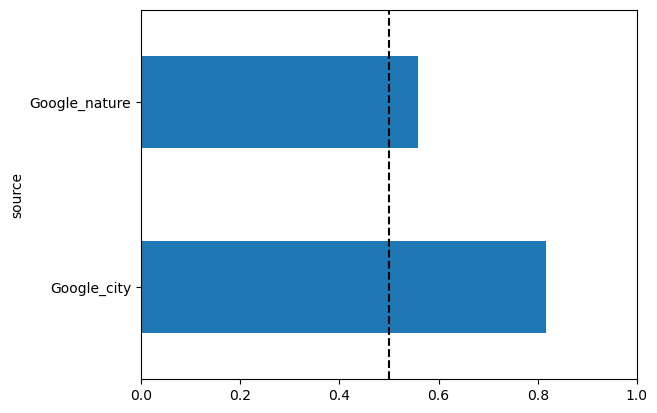

In [40]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of background signal

In [41]:
bg_model = get_model()

# raw_model = tf.keras.Sequential(Sequential_model, name='raw_model')

bg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 147,970
Trainable params: 147,970
Non-trai

In [42]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# bg_model.compile(loss=loss_func,
#                  optimizer=optimizer,
#                  weighted_metrics=['accuracy'],
#                  metrics=['accuracy'])


history_bg =bg_model.fit(train_ds_bg,
                         epochs=20,
                         validation_data=val_ds_bg,
                         callbacks=callback)

Epoch 1/20
7459/7459 [==============================] - 1002s 134ms/step - loss: 0.6191 - accuracy: 0.6574 - weighted_accuracy: 0.6574 - val_loss: 0.6201 - val_accuracy: 0.6575 - val_weighted_accuracy: 0.6575
Epoch 2/20
7459/7459 [==============================] - 17s 2ms/step - loss: 0.6118 - accuracy: 0.6644 - weighted_accuracy: 0.6644 - val_loss: 0.6223 - val_accuracy: 0.6576 - val_weighted_accuracy: 0.6576
Epoch 3/20
7459/7459 [==============================] - 17s 2ms/step - loss: 0.6117 - accuracy: 0.6635 - weighted_accuracy: 0.6635 - val_loss: 0.6197 - val_accuracy: 0.6637 - val_weighted_accuracy: 0.6637
Epoch 4/20
7459/7459 [==============================] - 17s 2ms/step - loss: 0.6111 - accuracy: 0.6637 - weighted_accuracy: 0.6637 - val_loss: 0.6199 - val_accuracy: 0.6617 - val_weighted_accuracy: 0.6617
Epoch 5/20
7459/7459 [==============================] - 18s 2ms/step - loss: 0.6107 - accuracy: 0.6648 - weighted_accuracy: 0.6648 - val_loss: 0.6191 - val_accuracy: 0.6622 - v

In [43]:
loss, accuracy, w_acc = bg_model.evaluate(test_ds_bg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

152/152 [==============================] - 10s 29ms/step - loss: 0.6349 - accuracy: 0.6368 - weighted_accuracy: 0.6368
Loss:  0.6348923444747925
Accuracy:  0.6368312835693359


In [44]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(bg_model, test_ds_bg, y_true = test_df['category'])
print(acc)

152/152 [==============================] - 0s 918us/step
0.6707818930041153


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_91010/3143404827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


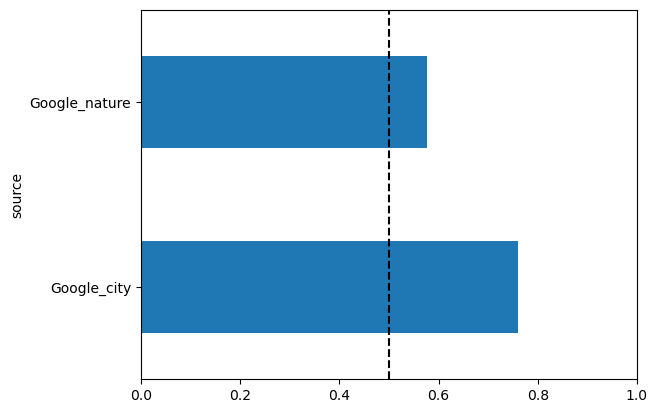

In [45]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of foreground signal

In [46]:
fg_model = get_model()

# raw_model = tf.keras.Sequential(Sequential_model, name='raw_model')

fg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 147,970
Trainable params: 147,970
Non-trai

In [48]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# fg_model.compile(loss=loss_func,
#                  optimizer=optimizer,
#                  weighted_metrics=['accuracy'],
#                  metrics=['accuracy'])


history_fg =fg_model.fit(train_ds_fg,
                         epochs=20,
                         validation_data=val_ds_fg,
                         callbacks=callback)

In [49]:
loss, accuracy, w_acc = fg_model.evaluate(test_ds_fg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [50]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(fg_model, test_ds_fg, y_true = test_df['category'])
print(acc)

In [51]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()